In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

# STEP 1: Camera Calibration

In [3]:
# as per the project instructions, the chessboard size is 9x6.
sizex = 9
sizey = 6

objpoints = []
imgpoints = []

objp = np.zeros((sizex*sizey,3), np.float32)
objp[:,:2] = np.mgrid[0:sizex,0:sizey].T.reshape(-1,2)

# read all chessboard images to be used for calibration 
images = glob.glob("camera_cal/calibration*.jpg")

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (sizex,sizey), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

img_shape = img.shape
        
# object and image points will be used to calculate the camera matrix and distortion coefficients which will later be used to undistort the image
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[:2],None,None)

## Undistortion and Testing The Camera Calibration

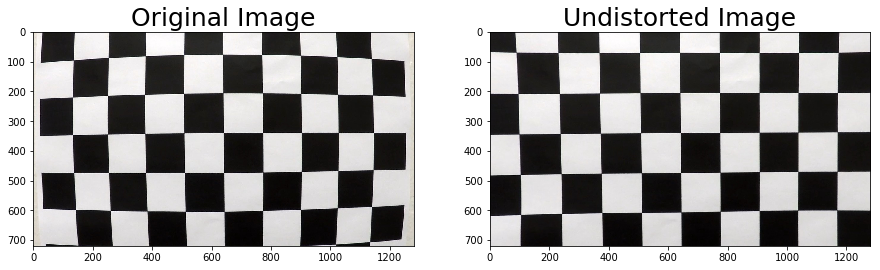

In [4]:
image = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
print('')

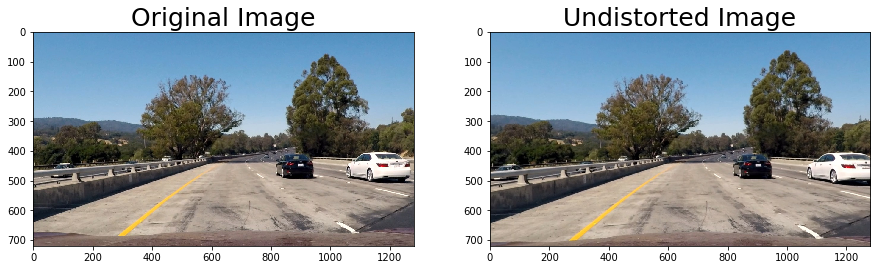

In [5]:
image = mpimg.imread('test_images/test1.jpg')
undistorted = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
print('')

# STEP 2: Image Thresholding

In [6]:
def thresholded_image(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    height, width = gray.shape
    
    # gradient threshold horizontally
    sx_binary = abs_sobel_threshold(gray, 'x', 10, 200)
    
    # gradient direction threshold
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combined threshold
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds to extract yellow lines
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # HLS threshold
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the previously applied thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # ROI threshold
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    
def abs_sobel_threshold(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return mask

## Testing Image Thresholding

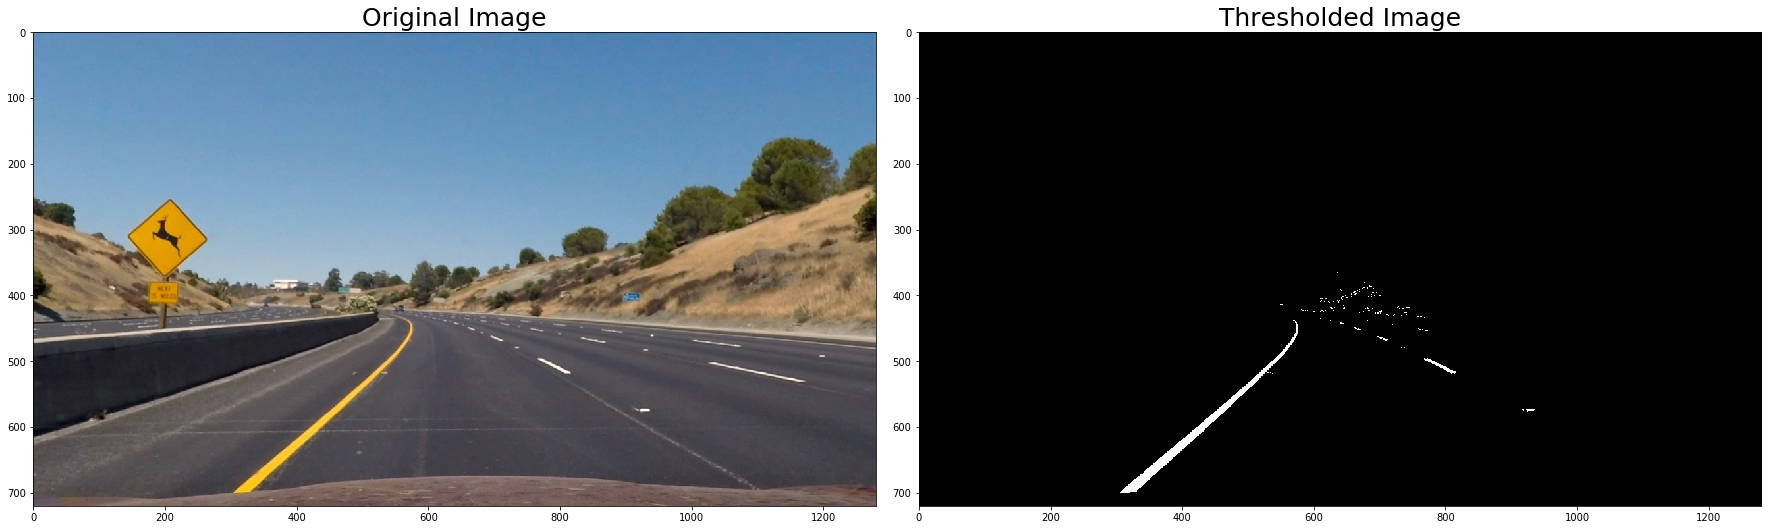

In [17]:
img = mpimg.imread('test_images/test2.jpg')
thresholded = thresholded_image(img)
img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('thresholded.jpg',thresholded)

# Plot the 2 images side by side
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# STEP 3: Perspective Transform

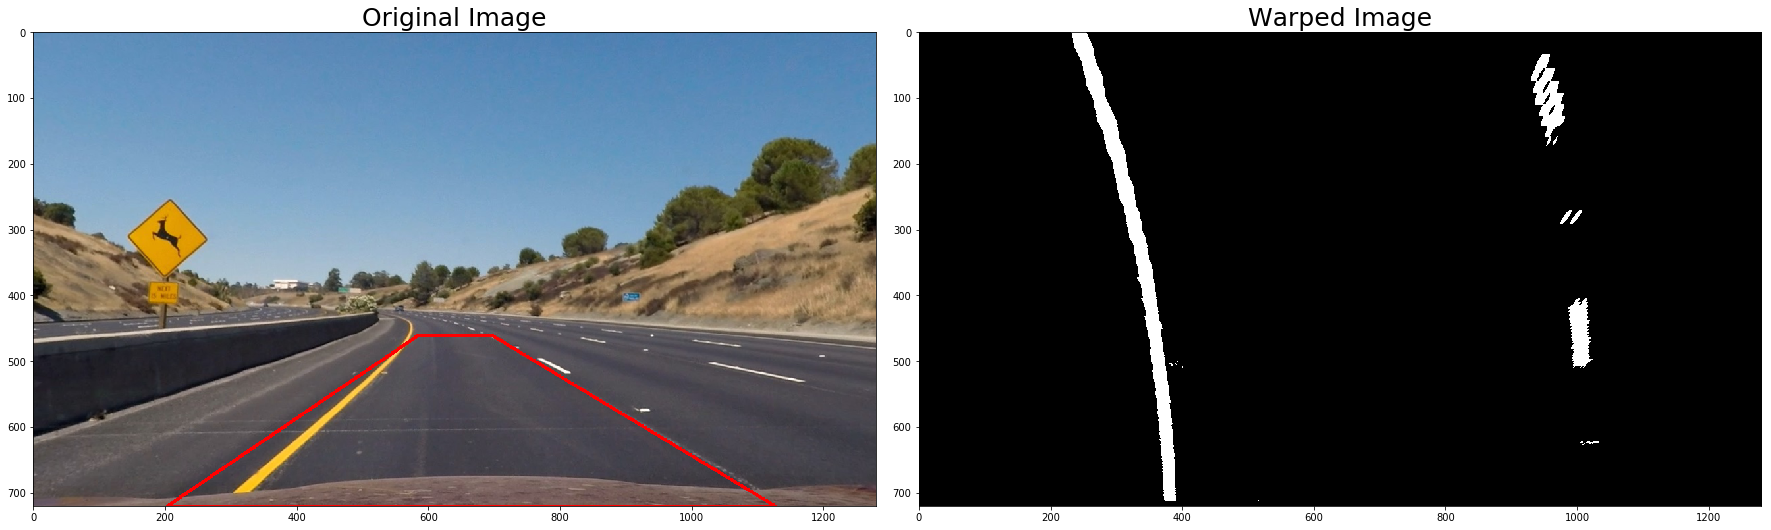

In [18]:
# perspective transform source points

#small
#bottom_left = [220,720]
#bottom_right = [1200, 720]
#top_left = [450, 550]
#top_right = [950, 550]

bottom_left = [203,720] #220, 720
bottom_right = [1127, 720] # 1110, 720
top_left = [585, 460] #400, 600
top_right = [696, 460] # 892, 600

src = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# perspective transform destination points
bottom_left = [320,720]
bottom_right = [960, 720]
top_left = [320, 0]
top_right = [960, 0]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
img_size = (img_shape[1], img_shape[0])

warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# STEP 4: Lane Lines Segmentation

## Left & Right Lines Histogram

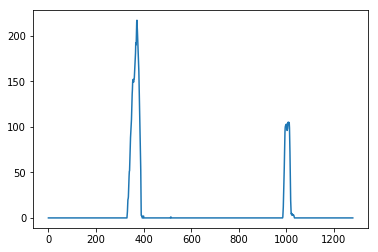

In [19]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

# Peak in the first half representing the likely position of the left line
half_width = np.int(histogram.shape[0]/2)
left_peak_x = np.argmax(histogram[:half_width])

# Peak in the second half representing the likely position of the right line
right_peak_x = np.argmax(histogram[half_width:]) + half_width

plt.plot(histogram)
print('')

## Sliding Window Search

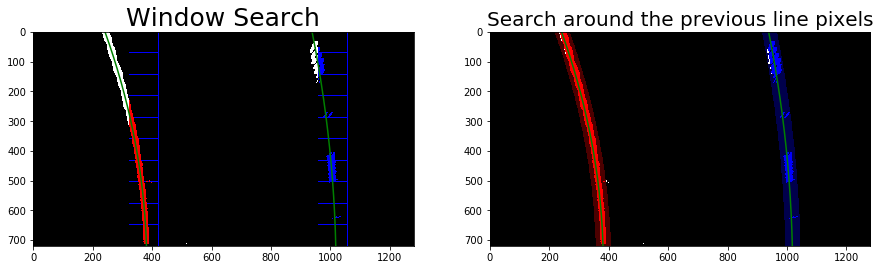

In [20]:
out_img = np.dstack((warped, warped, warped))*255

non_zeros = warped.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

num_windows = 10
num_rows = warped.shape[0]
window_height = np.int(num_rows/num_windows)
window_half_width = 50

min_pixels = 100

left_coordinates = []
right_coordinates = []

for window in range(num_windows):
    y_max = num_rows - window*window_height
    y_min = num_rows - (window+1)* window_height
    
    left_x_min = left_peak_x - window_half_width
    left_x_max = left_peak_x + window_half_width
    
    cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)
    
    good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    left_coordinates.append(good_left_window_coordinates)
    
    if len(good_left_window_coordinates) > min_pixels:
        leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))
    
    right_x_min = right_peak_x - window_half_width
    right_x_max = right_peak_x + window_half_width
    
    cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)
    
    good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
    right_coordinates.append(good_right_window_coordinates)
        
    if len(good_right_window_coordinates) > min_pixels:
        rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))
        
left_coordinates = np.concatenate(left_coordinates)
right_coordinates = np.concatenate(right_coordinates)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

margin = 25
out_filled = np.dstack((warped, warped, warped))*255

left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

out_filled[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_filled[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


left_x = non_zeros_x[left_coordinates]
left_y = non_zeros_y[left_coordinates]

polyfit_left = np.polyfit(left_y, left_x, 2)

right_x = non_zeros_x[right_coordinates]
right_y = non_zeros_y[right_coordinates]

polyfit_right = np.polyfit(right_y, right_x, 2)

y_points = np.linspace(0, num_rows-1, num_rows)

left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

windowed_img = np.zeros_like(out_filled)

left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

left_line_points = np.vstack((left_line_window_1, left_line_window_2))

cv2.fillPoly(windowed_img, np.int_([left_line_points]), [255,0, 0])

right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

right_line_points = np.vstack((right_line_window_1, right_line_window_2))

cv2.fillPoly(windowed_img, np.int_([right_line_points]), [0,0, 255])

result = cv2.addWeighted(out_filled, 1, windowed_img, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(out_img)
ax1.plot(left_x_predictions, y_points, color='green')
ax1.plot(right_x_predictions, y_points, color='green')
ax1.set_title('Window Search', fontsize=25)
ax2.imshow(result)
ax2.plot(left_x_predictions, y_points, color='green')
ax2.plot(right_x_predictions, y_points, color='green')
ax2.set_title('Search around the previous line pixels', fontsize=20)
print('')

## Filling the Lane

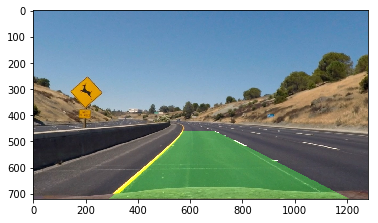

In [21]:
processed_img = np.dstack((warped, warped, warped))*255

y_points = np.linspace(0, num_rows-1, num_rows)

left_line = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
right_line = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

line_points = np.vstack((left_line, right_line))

cv2.fillPoly(processed_img, np.int_([line_points]), [0,255, 0])

unwarped = cv2.warpPerspective(processed_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)

plt.imshow(result)

print('')

In [22]:
def calculate_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    fit_circle = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curve = ((1 + (2*fit_circle[0]*y_eval*ym_per_pix + fit_circle[1])**2)**1.5) / np.absolute(2*fit_circle[0])
    return curve

left_curve_radius = calculate_curvature(left_x_predictions)
right_curve_radius = calculate_curvature(right_x_predictions)
average_curve_radius = (left_curve_radius + right_curve_radius) / 2
print("Radius of the lane curvature is %.2f m" % average_curve_radius)

# calculation of the offset from the center
lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x direction
center_offset_in_pixels = abs(img_size[0]/2 - lane_center)
center_offset_in_meters = xm_per_pix*center_offset_in_pixels
print("The center offset is %.2f m" % center_offset_in_meters)

Radius of the lane curvature is 1027.76 m
The center offset is 0.31 m


# Final Pipeline

In [23]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None
        
    def get_line(self, non_zeros_x, non_zeros_y, coordinates, num_rows):
        x = non_zeros_x[coordinates]
        y = non_zeros_y[coordinates]

        if(y.size == 0 or x.size == 0):
            self.detected = False
            return None, None

        self.current_fit = np.polyfit(y, x, 2)

        self.ally = np.linspace(0, num_rows-1, num_rows)

        self.allx = self.current_fit[0]*self.ally**2 + self.current_fit[1]*self.ally + self.current_fit[2]
        
        if self.allx is None:
            self.detected = False
        else:
            self.detected = True

        return self.allx
    
    def window_search(self, warped):
        non_zeros = warped.nonzero()
        non_zeros_y = non_zeros[0]
        non_zeros_x = non_zeros[1]

        num_rows = warped.shape[0]

        histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

        half_width = np.int(histogram.shape[0]/2)
        
        if self == Left:
            self.best_fit = np.argmax(histogram[:half_width])
        if self == Right:
            self.best_fit = np.argmax(histogram[half_width:]) + half_width

        num_windows = 10
        window_height = np.int(num_rows/num_windows)
        window_half_width = 50

        min_pixels = 100

        coordinates = []

        for window in range(num_windows):
            y_max = num_rows - window*window_height
            y_min = num_rows - (window+1)* window_height

            x_min = self.best_fit - window_half_width
            x_max = self.best_fit + window_half_width

            self.bestx = ((non_zeros_x >= x_min) & (non_zeros_x <= x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
            coordinates.append(self.bestx)

            if len(self.bestx) > min_pixels:
                self.bestfit = np.int(np.mean(non_zeros_x[self.bestx]))


        coordinates = np.concatenate(coordinates)

        self.allx = self.get_line(non_zeros_x, non_zeros_y, coordinates, num_rows)
        
        return self.allx
    
    def search_around_previous_line(self, warped):
        margin = 100
        non_zeros = warped.nonzero()
        non_zeros_y = non_zeros[0]
        non_zeros_x = non_zeros[1]

        self.allx = self.current_fit[0]*non_zeros_y**2 + self.current_fit[1]*non_zeros_y + self.current_fit[2]
        coordinates = ((non_zeros_x >= self.allx - margin) & (non_zeros_x <= self.allx + margin)).nonzero()[0]
     
        self.allx = self.get_line(non_zeros_x, non_zeros_y, coordinates, warped.shape[0])
        
        return self.allx
    
    def average_over_lines(self, previous_lines, new_line):
        num_frames = 10

        if new_line is None:
            if len(previous_lines) == 0:
                return previous_lines, None
            else:
                return previous_lines, previous_lines[-1]
        else:
            if len(previous_lines) < num_frames:
                previous_lines.append(new_line)
                return previous_lines, new_line
            else:
                previous_lines[0:num_frames-1] = previous_lines[1:]
                previous_lines[num_frames-1] = new_line
                new_line = np.zeros_like(new_line)
                for i in range(num_frames):
                    new_line += previous_lines[i]
                new_line /= num_frames
                return previous_lines, new_line
            
def get_lane(img):
    mean_difference_between_lines = 0
    
    bottom_left = [203,720]
    bottom_right = [1127, 720]
    top_left = [585, 460]
    top_right = [696, 460]

    src = np.float32([bottom_left,bottom_right,top_right,top_left])

    bottom_left = [320,720]
    bottom_right = [960, 720]
    top_left = [320, 0]
    top_right = [960, 0]
    
    dst = np.float32([bottom_left,bottom_right,top_right,top_left])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
  
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    thresholded = thresholded_image(img)    
    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    Left.ally = np.linspace(0, num_rows-1, num_rows)
    Right.ally = np.linspace(0, num_rows-1, num_rows)
       
    if Left.detected == False:
        Left.allx = Left.window_search(warped)
    elif Left.detected == True:
        Left.allx = Left.search_around_previous_line(warped)
    
    if Right.detected == False:
        Right.allx = Right.window_search(warped)
    elif Right.detected == True:
        Right.allx = Right.search_around_previous_line(warped)   
    
    if Left.allx is None:
        Left.allx = Left.window_search(warped)
    if Right.allx is None:
        Right.allx = Right.window_search(warped)
            
    bad_lines = False
            
    if (Left.detected == False) or (Right.detected == False):
        bad_lines = True
        Left.detected = False
        Right.detected = False

    else:
        mean_difference = np.mean(Right.allx - Left.allx)
        
        if mean_difference_between_lines == 0:
            mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*mean_difference_between_lines or mean_difference > 1.3*mean_difference_between_lines):
            bad_lines = True
            Left.detected = False
            Right.detected = False
            Left.allx = Left.window_search(warped)
            Right.allx = Right.window_search(warped)
            if (Left.allx is None or Right.allx is None):
                bad_lines = True
                Left.detected = False
                Right.detected = False
            else:
                mean_difference = np.mean(Right.allx - Left.allx)
                if (mean_difference < 0.7*mean_difference_between_lines or mean_difference > 1.3*mean_difference_between_lines):                        
                    bad_lines = True
                    Left.detected = False
                    Right.detected = False
                else:
                    bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        Left.current_fit = None
        Right.current_fit = None
        Left.detected = False
        Right.detected = False
        if len(Left.recent_xfitted) == 0 and len(Right.recent_xfitted) == 0:
            return img
        else:
            Left.allx = Left.recent_xfitted[-1]
            Right.allx = Right.recent_xfitted[-1]
    else:
        Left.recent_xfitted, Left.allx = Left.average_over_lines(Left.recent_xfitted, Left.allx)
        Right.recent_xfitted, Right.allx = Right.average_over_lines(Right.recent_xfitted, Right.allx)
        mean_difference = np.mean(Right.allx - Left.allx)
        mean_difference_between_lines = 0.9*mean_difference_between_lines + 0.1*mean_difference
    
    left_line = np.array(np.transpose(np.vstack([Left.allx, Left.ally])))
    right_line = np.array(np.flipud(np.transpose(np.vstack([Right.allx, Right.ally]))))
    
    # compute the radius of curvature
    Left.radius_of_curvature = calculate_curvature(Left.allx)
    Right.radius_of_curvature = calculate_curvature(Right.allx)
    average_curve_rad = (Left.radius_of_curvature + Right.radius_of_curvature)/2
    curvature_radius_string = "Radius of curvature = %.2f (m)" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (Right.allx[num_rows-1] + Left.allx[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Vehicle is %.2fm left of center" % center_offset_mtrs
    
    poly_points = np.vstack([left_line, right_line])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_radius_string , (30, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (30, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), thickness=2)
       
    return result

## Testing the Final Pipeline

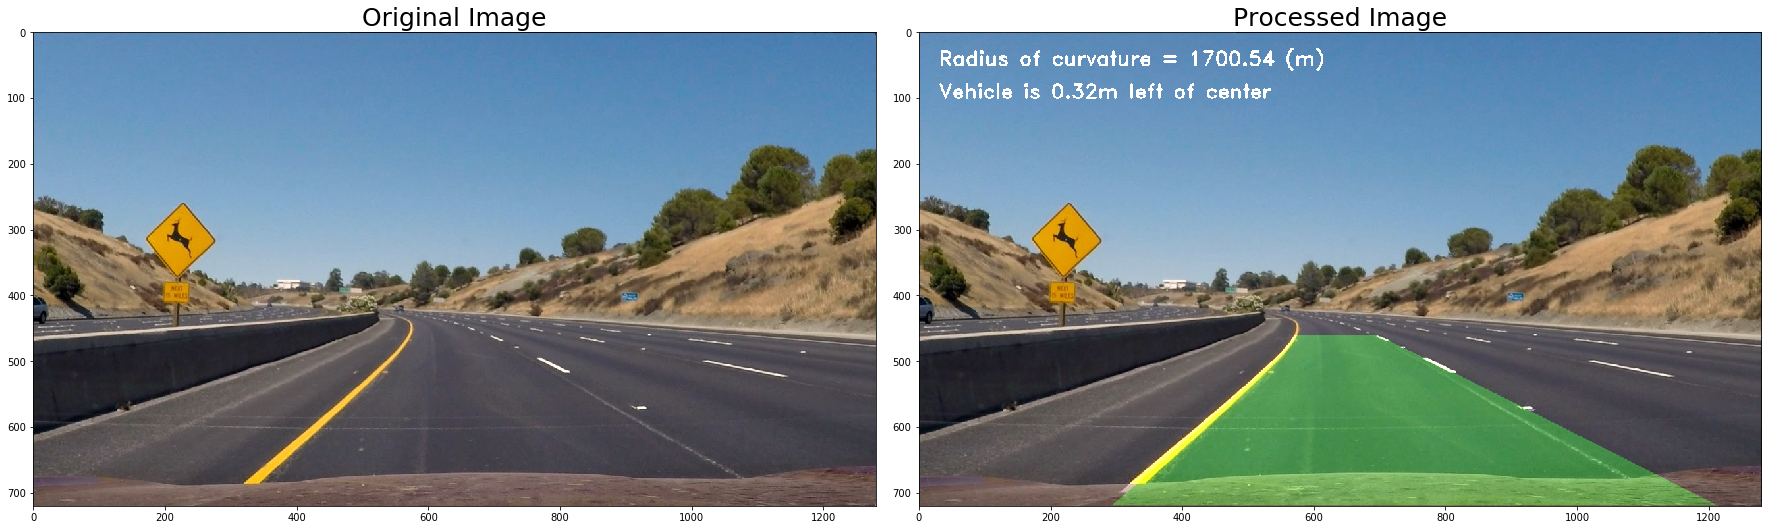

In [24]:
img = mpimg.imread('test_images/test2.jpg')

Left = Line()
Right = Line()
processed = get_lane(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Applying the Final Pipeline to Videos

In [25]:
from moviepy.editor import VideoFileClip

In [70]:
Left = Line()
Right = Line()
output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(get_lane)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [06:50<00:00,  3.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 3min 53s, sys: 51.3 s, total: 4min 44s
Wall time: 6min 53s


In [72]:
Left = Line()
Right = Line()
output = 'challenge_video_processed.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(get_lane)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_video_processed.mp4
[MoviePy] Writing video challenge_video_processed.mp4


100%|██████████| 485/485 [02:33<00:00,  3.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_processed.mp4 

CPU times: user 1min 28s, sys: 19.4 s, total: 1min 47s
Wall time: 2min 36s


In [26]:
Left = Line()
Right = Line()
output = 'harder_challenge_video_processed2.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(get_lane)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_processed2.mp4
[MoviePy] Writing video harder_challenge_video_processed2.mp4


100%|█████████▉| 1199/1200 [08:11<00:00,  2.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_processed2.mp4 

CPU times: user 4min 37s, sys: 57 s, total: 5min 34s
Wall time: 8min 15s
